# 675 project: Swin Transformer based experiments on ImageWoof. Benchmarks also include ResNet and RandomForest.

Following earlier instructions, the experiments were performed in a jupyter notebook.

-Follow the Swin-Transformer installation instructions https://github.com/microsoft/Swin-Transformer

In [1]:
#https://github.com/microsoft/Swin-Transformer

In [1]:
#%cd ./Swin-Transformer

D:\ProgramData\JupyterNB\Project\Swin-Transformer


In [7]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time

The models are imported from the Github repository. You may have to install the appropriate libraries as detailed in the orignal author Liu et al.'s readme.

In [8]:
from models.swin_transformer import SwinTransformer
from models.swin_mlp import SwinMLP
from models import build
import torchvision.models as models

In [9]:
WINDOW_SIZE = 7
IMG_SIZE = 224
NUM_CLASSES = 10

## Model parameters

We note the model defined here is the Swin-Transformer (Tiny) C24 variant from the original paper.

In [10]:
#Swin-Tiny - 29m parameter ~ ResNet50
#Swin-Small - 50m parameter ~ ResNet101

DATA_AUG = False
scale = 10
pretrain = True
name = "Transformer"

IMG_SIZE = 224

if name == "Transformer":
    IMG_SIZE = 224
    WINDOW_SIZE = 7

    PATCH_SIZE = 4
    IN_CHANS = 3
    EMBED_DIM = 96
    DEPTHS = [ 2, 2, 6, 2 ]
    NUM_HEADS = [ 3, 6, 12, 24 ]
    DROP_PATH_RATE = 0.2




MLP_RATIO = 4.
QKV_BIAS = True
QK_SCALE = None
APE = False
PATCH_NORM = True

DROP_RATE = 0.1
CLIP_GRAD = 5.0

EPOCHS = 50
WARMUP_EPOCHS = 5
WEIGHT_DECAY = 0.05
BASE_LR = 5e-4 * scale
WARMUP_LR = 5e-7 * scale
MIN_LR = 5e-6 * scale
LABEL_SMOOTHING = 0.1
BETAS = (0.9, 0.999)

## Model Initialization

We have options to load in ImageNet1k Pretrained weights for transfer learning.

In [11]:
if pretrain:
    NUM_CLASSES2 = 1000
else:
    NUM_CLASSES2 = NUM_CLASSES
    

if name == "Transformer":
    model = SwinTransformer(img_size=IMG_SIZE,
                                patch_size=PATCH_SIZE,
                                in_chans=IN_CHANS,
                                num_classes=NUM_CLASSES2,
                                embed_dim=EMBED_DIM,
                                depths=DEPTHS,
                                num_heads=NUM_HEADS,
                                window_size=WINDOW_SIZE,
                                mlp_ratio=MLP_RATIO,
                                qkv_bias=QKV_BIAS,
                                qk_scale=QK_SCALE,
                                drop_rate=DROP_RATE,
                                drop_path_rate=DROP_PATH_RATE,
                                ape=APE,
                                patch_norm=PATCH_NORM)
    if pretrain:
        weights = torch.load("swin_tiny_patch4_window7_224.pth")
        model.load_state_dict(weights['model'])
        model.head = torch.nn.Linear(in_features = 768, out_features = NUM_CLASSES, bias = True) 
        print("weights loaded")
        #weights['model']

if name =="ResNet":
    model = torchvision.models.resnet50(pretrained=pretrain)
    model.fc = torch.nn.Linear(in_features = 2048, out_features = NUM_CLASSES, bias = True) 
    model = model.cuda()    

model = model.cuda()
best_val_acc = 0

## Data augmentation and data pipeline from timm library

We note that the data augmentation is the most vital part to the successful training. Without this, models show overfitting even with methods which decrease model complexity (weight regularization, dropout).

In [13]:
import torch.distributed as dist
from torchvision import datasets, transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.data import Mixup
from timm.data import create_transform
from torchvision.transforms import InterpolationMode

def _pil_interp(method):
    if method == 'bicubic':
        return InterpolationMode.BICUBIC
    elif method == 'lanczos':
        return InterpolationMode.LANCZOS
    elif method == 'hamming':
        return InterpolationMode.HAMMING
    else:
            # default bilinear, do we want to allow nearest?
        return InterpolationMode.BILINEAR

def build_transform(is_train):
    resize_im = IMG_SIZE > 32
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=IMG_SIZE,
            is_training=True,
            color_jitter=COLOR_JITTER if COLOR_JITTER > 0 else None,
            auto_augment=AUTO_AUGMENT if AUTO_AUGMENT != 'none' else None,
            re_prob=REPROB,
            re_mode=REMODE,
            re_count=RECOUNT,
            interpolation=INTERPOLATION,
        )
        if not resize_im:
            # replace RandomResizedCropAndInterpolation with
            # RandomCrop
            transform.transforms[0] = transforms.RandomCrop(config.DATA.IMG_SIZE, padding=4)
        return transform

    t = []
    if resize_im:
        if CROP:
            size = int((256 / 224) * IMG_SIZE)
            t.append(
                transforms.Resize(size, interpolation=_pil_interp(INTERPOLATION)),
                # to maintain same ratio w.r.t. 224 images
            )
            t.append(transforms.CenterCrop(IMG_SIZE))
        else:
            t.append(
                transforms.Resize((IMG_SIZE, IMG_SIZE),
                                  interpolation=_pil_interp(INTERPOLATION))
            )

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
    return transforms.Compose(t)

In [14]:
import os
from torchvision import transforms
import time

## Build dataset and data loader 

We use two separate pipelines, one for training and one for validation sets.

## ImageWoof 
contains 9025 training images and 3929 validation images

In [15]:


train_transform = build_transform(True)
val_transform = build_transform(False)

imagewoof_train = torchvision.datasets.ImageFolder("./imagewoof2_320/train",transform=train_transform)
imagewoof_val = torchvision.datasets.ImageFolder("./imagewoof2_320/val",transform=val_transform)

train_loader = torch.utils.data.DataLoader(imagewoof_train,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=True
                                          )
val_loader = torch.utils.data.DataLoader(imagewoof_val,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=True
                                        )

'\nimg_transform = transforms.Compose(\n        [transforms.ToTensor(),\n         transforms.Resize([224, 224]),\n        ])\n\nimagewoof_train = torchvision.datasets.ImageFolder("./imagewoof2_320/train",transform=img_transform)\nimagewoof_val = torchvision.datasets.ImageFolder("./imagewoof2_320/val",transform=img_transform)'

In [17]:
from timm.scheduler.cosine_lr import CosineLRScheduler
from timm.scheduler.scheduler import Scheduler
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy

In [18]:
num_train_imgs = (len(imagewoof_train.imgs))
num_val_imgs = (len(imagewoof_val.imgs))

In [19]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
train_time = []

best_val_acc = 0
    
n_iter_per_epoch = len(train_loader)

## Cosine scheduler

In [20]:
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy

if MIXUP > 0.:
        # smoothing is handled with mixup label transform
        loss_fn = SoftTargetCrossEntropy()
elif LABEL_SMOOTHING > 0.:
        loss_fn = LabelSmoothingCrossEntropy(smoothing=LABEL_SMOOTHING)
else:
        loss_fn = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.AdamW(model.parameters(),lr = BASE_LR, weight_decay = 0 ,betas = BETAS)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.1, nesterov=True,lr=BASE_LR) #momentum factor in pytorch is 1-Beta

In [21]:
num_steps = EPOCHS*n_iter_per_epoch
warmup_steps = WARMUP_EPOCHS*n_iter_per_epoch

lr_scheduler = CosineLRScheduler(
            optimizer = optimizer,
            t_initial=num_steps,
            lr_min=MIN_LR,
            warmup_lr_init=WARMUP_LR,
            warmup_t=warmup_steps,
            cycle_limit=1,
            t_in_epochs=False,
        )

'lr_scheduler = CosineLRScheduler(\n            optimizer = optimizer,\n            t_initial=num_steps,\n            lr_min=MIN_LR,\n            warmup_lr_init=WARMUP_LR,\n            warmup_t=warmup_steps,\n            cycle_limit=1,\n            t_in_epochs=False,\n        )'

## The training loop

The training loop was written by myself. The training script from the original authors did not work on my computer due to PyTorch version mismatch.

In [23]:


for epoch in range(50):
    
    t1=time.time()
    train_loss = 0
    train_acc = 0
    
    
    for idx,(imgs,labels) in enumerate(train_loader):        
        imgs = imgs.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)
        labels_oh = torch.nn.functional.one_hot(labels,NUM_CLASSES)
        
        
        
        predictions = model(imgs)
        loss = loss_fn(predictions,labels_oh)
        
        optimizer.zero_grad()
        loss.backward()        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD)        
        optimizer.step()
        
        #lr_scheduler.step_update(epoch * n_iter_per_epoch + idx)
        predictions = torch.argmax(predictions,axis=1)
        train_acc += float(torch.sum(predictions==labels))
        train_loss += float(loss)
    
    train_acc = train_acc / num_train_imgs
    train_accs.append(train_acc)
    
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    print("Training loss : {}".format(train_loss))
    print("Training accuracy: {}".format(train_acc))
    
    val_acc = 0
    val_loss = 0
    

    
    
    for imgs,labels in val_loader:
        imgs = imgs.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)
        
        
        labels_oh = torch.nn.functional.one_hot(labels,NUM_CLASSES)
        predictions = model(imgs)
        loss = loss_fn(predictions,labels_oh)
        predictions = torch.argmax(predictions,axis=1)
        acc = torch.sum(predictions==labels)
        val_acc += float(acc)
        
        val_loss += float(loss)
    

    val_acc = val_acc/num_val_imgs
    

    val_loss = val_loss / len(val_loader)
    

    val_losses.append(val_loss)
    val_accs.append(val_acc) 
    
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), "./save_models/ImageNette_200.pth")
        best_val_acc = val_acc
        best_epoch = epoch
        
    t2 = time.time()
    train_time.append(t2-t1)
    
    print("Epoch {}, time: {}".format(epoch,t2-t1))

    print("Validation loss : {}".format(val_loss))
    print("Validation accuracy: {}".format(val_acc))
#cuda out of memory if we do not convert loss to float(loss) before accumulating

Training loss : 0.44309748229669765
Training accuracy: 0.8549584487534626
Epoch 0, time: 74.9822359085083
Validation loss : 0.18189659449586107
Validation accuracy: 0.9409518961567829
Training loss : 0.44999176414406045
Training accuracy: 0.8537396121883657
Epoch 1, time: 75.6778998374939
Validation loss : 0.17693117476336978
Validation accuracy: 0.9414609315347416
Training loss : 0.4512095098046863
Training accuracy: 0.8522991689750693
Epoch 2, time: 73.61489915847778
Validation loss : 0.17550879968273128
Validation accuracy: 0.9432425553575974
Training loss : 0.4561414265549405
Training accuracy: 0.850415512465374
Epoch 3, time: 72.87978982925415
Validation loss : 0.17337044320452066
Validation accuracy: 0.9419699669127004
Training loss : 0.43437231653072733
Training accuracy: 0.8603878116343491
Epoch 4, time: 74.05132603645325
Validation loss : 0.18350215154511432
Validation accuracy: 0.9419699669127004
Training loss : 0.45710634513500525
Training accuracy: 0.8477562326869806
Epoch 

Training loss : 0.39522572756903446
Training accuracy: 0.870027700831025
Epoch 45, time: 78.048255443573
Validation loss : 0.1510975414349989
Validation accuracy: 0.9508780860269789
Training loss : 0.40016489485873186
Training accuracy: 0.8678116343490305
Epoch 46, time: 72.2585780620575
Validation loss : 0.16289980453581898
Validation accuracy: 0.94629676762535
Training loss : 0.4048631748239054
Training accuracy: 0.8654847645429363
Epoch 47, time: 72.86792588233948
Validation loss : 0.15353418582696124
Validation accuracy: 0.9490964622041231
Training loss : 0.41421998324903087
Training accuracy: 0.8638227146814405
Epoch 48, time: 72.21913552284241
Validation loss : 0.1557151104603534
Validation accuracy: 0.9452786968694324
Training loss : 0.4022356240039176
Training accuracy: 0.8682548476454294
Epoch 49, time: 72.41797208786011
Validation loss : 0.15855733757164397
Validation accuracy: 0.9473148383812675


In [25]:
model.eval() #Turn off dropout and drop-path
print(best_epoch)

20

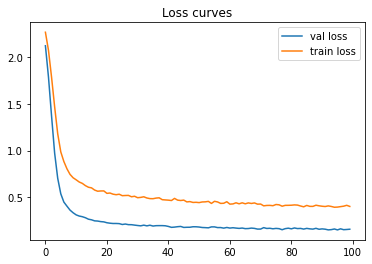

In [28]:
plt.plot(val_losses,label='val loss')
plt.plot(train_losses,label='train loss')
plt.legend()
plt.title('Loss curves')
plt.show()

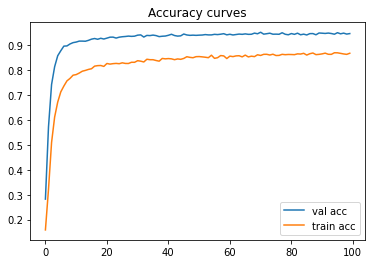

In [29]:
plt.plot(val_accs,label='val acc')
plt.plot(train_accs,label='train acc')
plt.legend()
plt.title('Accuracy curves')
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,jaccard_score,precision_score,recall_score

We make a list of validation set predictions

In [24]:
Y_val = torch.Tensor([]).cuda()
Y_val_pred = torch.Tensor([]).cuda()

for imgs,labels in val_loader:
    imgs = imgs.cuda()
    labels = labels.cuda()
    predictions = model(imgs)
    predictions = torch.argmax(predictions,axis=1)
    Y_val_pred = torch.cat((Y_val_pred,predictions))
    Y_val = torch.cat((Y_val, labels))

In [25]:
Y_val_pred = Y_val_pred.cpu()
Y_val = Y_val.cpu()

## We note the impressive validation accuracy score, exceeding the ImageWoof benchmarks by 5%. 

The validation accuracy calculated here is different from the one in the training loop because we did not turn off dropout and drop-path in the training loop. We do however turn it off at the end of the training loop

In [32]:
accuracy_score(Y_val,Y_val_pred)

0.950920245398773

In [33]:
woof_labels = ['Shih-Tzu','Rhodesian ridgeback','Beagle','English foxhound','Australian terrier','Border terrier','Golden retriever','Old English sheepdog','Samoyed',
'Dingo']

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_train,Y_train_pred,xticks_rotation = 'vertical', normalize = 'true',display_labels = imagenette_val.classes,values_format='.1g')

In [13]:
imgs,labels = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

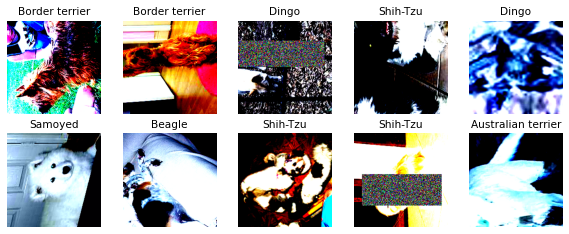

In [14]:
woof_labels = ['Shih-Tzu','Rhodesian ridgeback','Beagle','English foxhound','Australian terrier','Border terrier','Golden retriever','Old English sheepdog','Samoyed',
'Dingo']
fig10 = plt.figure(figsize = (10, 10))
d = 0
for r in range(5):
  for c in range(2):
    fig10.add_subplot(5, 5, d+1)
    imgs_plot = imgs.cpu()
    plt.imshow(imgs_plot[d,:,:,:].transpose(0,2))
    plt.axis('off')
    label = labels[d].item()
    plt.title(woof_labels[label], color = 'black',fontsize=10.5)
    d = d+1  